# Point 5

In [1]:
import torch
import torchvision
from tqdm import trange
import cv2
from torchvision import transforms
from torch.utils.data import random_split, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import copy
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(10)

device = torch.device("cpu")

print(device)

cpu


In [2]:
# Since after we use early stopping this line is just to remove the best saved model if it's already present

!rm best_model.pt

rm: cannot remove 'best_model.pt': No such file or directory


## Train and Test set transformation definition

We are applying data augmentation only on the train set (only random horizontal flips), not the test set

In [3]:
train_transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((64, 64)),
    transforms.PILToTensor()
    
])

test_transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.Resize((64, 64)),
    transforms.PILToTensor()
])

## Dataset Definition

The following dataset is devided as follows:

- train folder: 15% validation set, 85% training set
- test folder: 100% testset
- batch size: 32

In [4]:
BATCH_SIZE = 32

trainset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/train/', loader=Image.open)

trainset_classes = trainset.classes.copy()

subset_size = int(0.15*len(trainset))

validset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/train/', loader=Image.open)

indices = torch.randperm(len(trainset))

valid_indices = indices[:subset_size]
train_indices = indices[subset_size:]

trainset = Subset(trainset, train_indices)
validset = Subset(validset, valid_indices)

# Apply transformations only to the training set
trainset.dataset.transform = train_transform
# Apply transformations to the validation set
validset.dataset.transform = test_transform

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

testset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/test/', transform=test_transform, loader=Image.open)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin

print(f'entire train folder: {len(trainset)}, entire test folder: {len(testset)}, splitted trainset: {len(trainset)},  splitted validset: {len(validset)}')

entire train folder: 1275, entire test folder: 2985, splitted trainset: 1275,  splitted validset: 225


## Architecture design

In [5]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(8),
                torch.nn.MaxPool2d(kernel_size=2, stride=2),
                torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(16),
                torch.nn.MaxPool2d(kernel_size=2, stride=2),
                torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
                torch.nn.BatchNorm2d(32),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2, stride=2),
                torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
                torch.nn.BatchNorm2d(64),
                torch.nn.ReLU()
        )
        
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(64*4*4, 15)
        )

    def forward(self, x):
        x = x.float()
        return self.classifier(self.conv(x))

model = CNN().to(device)

## Weight initialization

In [6]:
def initialize_weigths_and_bias(m):
  if (type(m) == torch.nn.Linear) or (type(m) == torch.nn.Conv2d):
      torch.nn.init.constant_(m.bias.data, 0) # initialize weights
      torch.nn.init.normal_(m.weight.data, mean=0.0, std=0.01)
      # torch.nn.init.kaiming_uniform_(m.weight.data, mode='fan_in', nonlinearity='relu')
  

model.apply(initialize_weigths_and_bias)

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, en

In [7]:
# This function is used just to check if the dataset is correctly loaded and transformed

def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

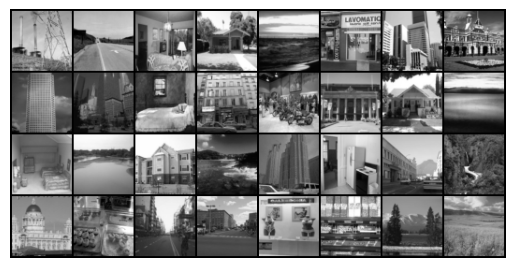

In [8]:
images, labels = next(iter(trainloader))

imshow(torchvision.utils.make_grid(images))

In [9]:
# Checking initialization printing mean, std, max biases in the classifier fully connected layer

model.classifier[1].weight.mean(), model.classifier[1].weight.std(), model.classifier[1].bias.max()

(tensor(-8.0025e-05, grad_fn=<MeanBackward0>),
 tensor(0.0100, grad_fn=<StdBackward0>),
 tensor(0., grad_fn=<MaxBackward1>))

In [10]:
# Checking initialization printing mean, std, max biases in the first convolution layer

model.conv[0].weight.mean(), model.conv[0].weight.std(), model.conv[0].bias.max()

(tensor(0.0009, grad_fn=<MeanBackward0>),
 tensor(0.0100, grad_fn=<StdBackward0>),
 tensor(0., grad_fn=<MaxBackward1>))

In [11]:
# This function returns the accuracy of the model

def get_accuracy(model, dataloader):
    model.eval()
    with torch.no_grad():
        correct=0
        for x, y in iter(dataloader):
            x = x.to(device)
            y = y.to(device)
            out=model(x)
            correct+=(torch.argmax(out, axis=1)==y).sum()
        return correct/len(dataloader.dataset)

In [12]:
# Definitition of the optimizer and loss function

# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [13]:
# This function trains the model for one epoch

def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0
    for x, y in iter(loader):
        x = x.to(device)
        y = y.to(device)
        out=model(x)
        l=loss(out, y)
        running_loss += l.item()
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    return running_loss/len(loader.dataset)
    

In [14]:
# This function is used to return in a tuple the whole prediction of the testset and the corresponding true labels

def get_test_predictions(model, test_loader):
    pred_tens = torch.empty(len(test_loader.dataset), dtype=torch.uint8)
    labels_tens = torch.empty_like(pred_tens)

    for i, data in enumerate(test_loader):
        x, y = data
        x = x.to(device)
        y = y.to(device)
        prediction = model(x)

        prediction = torch.argmax(prediction, axis=1)

        # Calculate the proper indices for assignment
        start_idx = i * test_loader.batch_size
        end_idx = start_idx + x.size(0)
    
        pred_tens[start_idx:end_idx] = copy.deepcopy(prediction)
        labels_tens[start_idx:end_idx] = copy.deepcopy(y)
    
    return (pred_tens, labels_tens)

In [15]:
# Training loop

epochs = 50
losses = []
accuracies = []
for epoch in trange(epochs, desc="Training: ", unit="epoch"):
    accuracy = get_accuracy(model, validloader)
    accuracies.append(accuracy)
    curr_loss = train_one_epoch(model, trainloader, optimizer)
    losses.append(curr_loss)
print(f"Final accuracy: {get_accuracy(model, validloader)}")

Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training: 100%|██████████| 50/50 [02:43<00:00,  3.27s/epoch]


Final accuracy: 0.4266666769981384


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


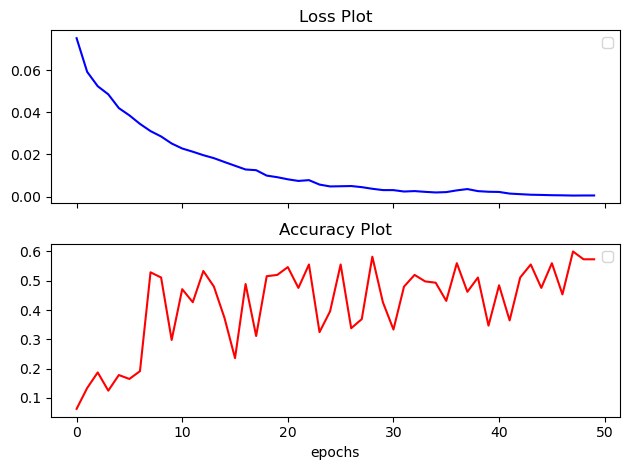

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot data on the first subplot
ax1.plot(losses, color='blue')
ax1.set_title('Loss Plot')
ax1.legend()

# Plot data on the second subplot
ax2.plot(accuracies, color='red')
ax2.set_title('Accuracy Plot')
ax2.legend()

# Add a common x-axis label
plt.xlabel('epochs')
plt.tight_layout()

# Show the plot
plt.show()

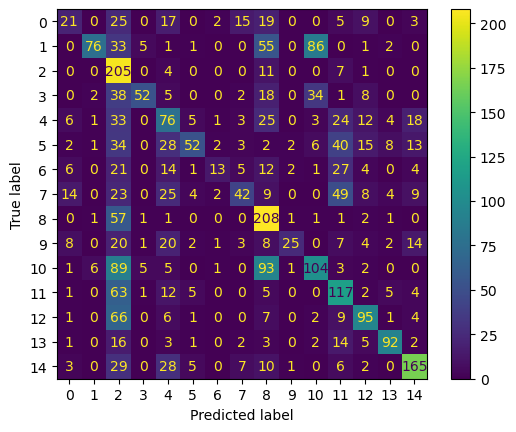

In [17]:
# Here we are calculating the cofusion matrix

pred_tensor, labels_tensor = get_test_predictions(model, testloader)

pred_array = pred_tensor.numpy()
labels_array = labels_tensor.numpy()

cm = confusion_matrix(labels_array, pred_array, labels=[*range(0, len(trainset_classes))])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[*range(0, len(trainset_classes))])

disp.plot()

plt.show()

In [18]:
# Here we are definig the model for the early stopping strategy

es_model = CNN().to(device) # early stopping model
es_opt = torch.optim.Adam(es_model.parameters(), lr=0.001)

es_model.apply(initialize_weigths_and_bias)

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, en

## Early Stoping

This loop is a simple early stopping implemetation; it uses GL as a stopping criterion to know if we are "overfitting" model.
At every iteration it checks if the previous model did better than the last one and if so, saves it.

In [19]:
GL = lambda val_err, opt_err: 100*((val_err/opt_err) - 1) # GL measure based on the cited paper

MAX_EPOCHS = 1000
epoch = 0

alpha = 100

accuracies = []
losses = []
valid_errors = []

SAVE_PATH = 'best_model.pt'

optimal_error = np.inf
validation_error = 0


while(GL(validation_error, optimal_error) < alpha and epoch < MAX_EPOCHS):
	alpha *= 0.95
	one_epoch_loss = train_one_epoch(es_model, trainloader, es_opt)
	epoch += 1
	validation_error = 1 - get_accuracy(es_model, validloader)
	print(f"Epoch: {epoch : 04d}, Test loss: {one_epoch_loss : .05f}, GL: {GL(validation_error, optimal_error): e}, error: {validation_error: e}", end="\r")

	losses.append(one_epoch_loss)
	accuracies.append(1 - validation_error)

	if validation_error < optimal_error:
		optimal_error = validation_error
		torch.save({
			"model_state_dict": es_model.state_dict(),
			"optimizer_state_dict": es_opt.state_dict()
		}, SAVE_PATH)
print('\r')
print(f'GL: {GL(validation_error, optimal_error)}')

Epoch:  010, Test loss:  0.02251, GL:  7.582417e+01, error:  7.111111e-01
GL: 75.82416534423828


In [20]:
# Here we are loading the best early stopping model

es_model = CNN().to(device)
checkpoint = torch.load(SAVE_PATH)
es_model.load_state_dict(checkpoint["model_state_dict"])

print(f"Final accuracy: {get_accuracy(es_model, validloader)}")

Final accuracy: 0.5955555438995361


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


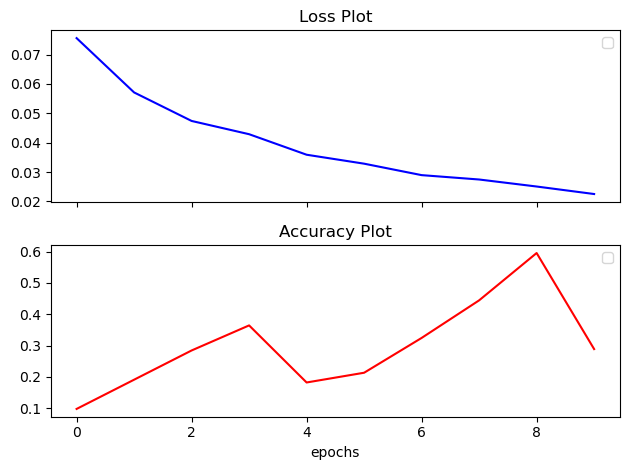

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot data on the first subplot
ax1.plot(losses, color='blue')
ax1.set_title('Loss Plot')
ax1.legend()

# Plot data on the second subplot
ax2.plot(accuracies, color='red')
ax2.set_title('Accuracy Plot')
ax2.legend()

# Add a common x-axis label
plt.xlabel('epochs')
plt.tight_layout()

# Show the plot
plt.show()

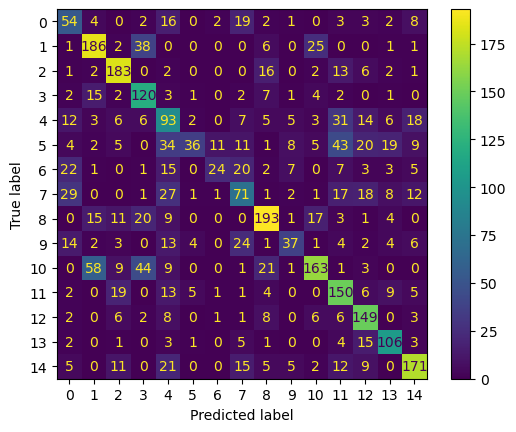

In [22]:
# Here we are calculating the cofusion matrix

pred_tensor, labels_tensor = get_test_predictions(es_model, testloader)

pred_array = pred_tensor.numpy()
labels_array = labels_tensor.numpy()

cm = confusion_matrix(labels_array, pred_array, labels=[*range(0, len(trainset_classes))])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[*range(0, len(trainset_classes))])

disp.plot()

plt.show()

## Printing dataset classes and respective number of elemts per class

In [23]:
trainset_classes

['Bedroom',
 'Coast',
 'Forest',
 'Highway',
 'Industrial',
 'InsideCity',
 'Kitchen',
 'LivingRoom',
 'Mountain',
 'Office',
 'OpenCountry',
 'Store',
 'Street',
 'Suburb',
 'TallBuilding']

In [24]:
## Stampa numero immagini per classe per vedere se dataset è bilanciato
np.sum(cm, axis=1)

array([116, 260, 228, 160, 211, 208, 110, 189, 274, 115, 310, 215, 192,
       141, 256], dtype=int64)